# Exercise 3: Language modelling

In this lab you will implement and train two neural language models: one based on a simple feed-forward architecture and one based on a recurrent neural network. You will evaluate these models by computing their perplexity on a benchmark dataset.

In [ ]:
import torch

If possible, use a GPU:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using', device)

## Data

The data for this lab is the same as for Exercise&nbsp;1: [WikiText](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/), a collection of more than 100 million tokens extracted from the set of &lsquo;Good&rsquo; and &lsquo;Featured&rsquo; articles on Wikipedia. We will use the small version of the dataset, which contains slightly more than 2.5 million tokens.

The next cell contains code for an object that will act as a container for the &lsquo;training&rsquo; and the &lsquo;validation&rsquo; section of the data. The only processing that we need to do is to whitespace-tokenize and replace each newline character with a special token `<eos>` (end-of-sentence) token.

In [ ]:
class WikiText(object):
    
    def __init__(self):
        self.vocab = {}
        self.train = self.read_data('wiki.train.tokens')
        self.valid = self.read_data('wiki.valid.tokens')
    
    def read_data(self, path):
        ids = []
        with open(path) as source:
            for line in source:
                for token in line.split() + ['<eos>']:
                    if token not in self.vocab:
                        self.vocab[token] = len(self.vocab)
                    ids.append(self.vocab[token])
        return ids

Here is the specification of the fields in the container object:

**vocab**

> A dictionary mapping the unique words in the WikiText data to a contiguous range of integers between&nbsp;$0$ and $V-1$, where $V$ is the total number of unique words. Note that the vocabulary includes the special end-of-sentence marker.

**train** and **valid**

> Lists of integers representing the tokens (including the end-of-sentence tokens) in the &lsquo;training&rsquo; and the &lsquo;validation&rsquo; section of the data, respectively. Each token is represented by its index in the vocabulary.

Running the following cell will print the total number of tokens and the size of the vocabulary in the WikiText data.

In [ ]:
wikitext = WikiText()

print('Tokens in train:', len(wikitext.train))
print('Tokens in valid:', len(wikitext.valid))
print('Vocabulary size:', len(wikitext.vocab))

## Feed-forward neural language model

In this section you will implement and train the neural $n$-gram language model proposed by [Bengio et al. (2003)](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). The core of this model is a feed-forward neural network that predicts the next word in a text, given the $n-1$ preceding words. The architecture of the model is shown below.

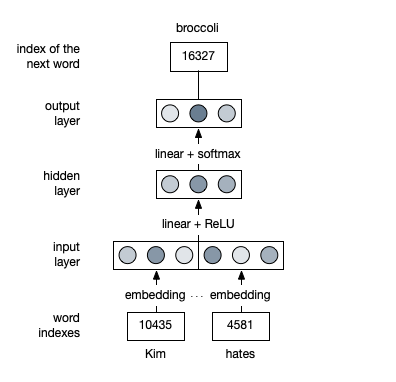

An input to the network takes the form of a vector of $n-1$ integers representing the preceding words. Each integer is mapped to a vector via an embedding layer. (All positions share the same embedding.) The embedding vectors are then concatenated and sent through a linear transformation, followed by a rectified linear unit (ReLU) transfer function. The output of this &lsquo;hidden&rsquo; layer is sent through a second linear transformation into a final softmax layer.

### Part 1: Vectorize the data

The code in the next cell transforms the data in the WikiText container into a vectorized form that can be fed to the feed-forward network.

In [ ]:
def vectorize_ffn(wikitext_data, n):
    xs, ys = [], []
    for i in range(0, len(wikitext_data) - n + 1):
        xs.append(wikitext_data[i:i+n-1])
        ys.append(wikitext_data[i+n-1])
    return torch.LongTensor(xs), torch.LongTensor(ys)

The function transforms a list of token indexes into a pair of tensors $\mathbf{X}$, $\mathbf{y}$. Let $N$ be the total number of $n$-grams from the token list; then $\mathbf{X}$ is a matrix with shape $(N, n-1)$ (representing the contexts) and $\mathbf{y}$ is a vector with length $N$ (representing the next words).

Check whether you understand the representation by running the following cell:

In [ ]:
valid_x, valid_y = vectorize_ffn(wikitext.valid, 3)

print(valid_x.size(), valid_y.size())

### Part 2: Implement the model

Your task now is to implement the network model based on the graphical specification in the picture above.

In [ ]:
import torch.nn as nn

class FFNModel(nn.Module):

    def __init__(self, n, n_words, embedding_dim=50, hidden_dim=50):
        super().__init__()
        # TODO: Add your own code

    def forward(self, x):
        # TODO: Replace the next line with your own code
        raise NotImplemented

Here is the specification of the two methods:

**__init__** (*self*, *n*, *n_words*, *embedding_dim*=50, *hidden_dim*=50)

> Creates a new feed-forward neural language model. The argument *n* specifies the model&rsquo;s $n$-gram order. The argument *n_words* is the number of words that need to be embedded. The optional arguments *embedding_dim* and *hidden_dim* specify the dimensionalities of the embedding layer and the hidden layer, respectively; their default value is 50.

**forward** (*self*, *x*)

> Computes the network output on an input batch *x*. The shape of *x* is $(B, n-1)$, where $B$ is the batch size. The output of the forward pass is a tensor of shape $(B, V)$ where $V$ is the number of words in the vocabulary.

### Part 3: Train the model

Your next task is to write code to train the language model using minibatch gradient descent and the cross-entropy loss function.

For your convenience, the following cell contains a utility function that randomly samples minibatches of a specified size from a pair of tensors:

In [ ]:
def batchify(x, y, batch_size):
    random_indices = torch.randperm(len(x))
    for i in range(0, len(x) - batch_size + 1, batch_size):
        indices = random_indices[i:i+batch_size]
        yield x[indices].to(device), y[indices].to(device)

We also provide a class `LossUpdater` that encapsulates convenience functionality for maintaining a running cross-entropy loss during mini-batch training. The running loss is updated at the end of each batch by calling the `loss` method with the network output and the target values as arguments; this returns the per-batch loss. To return the perplexity corresponding to the current loss, use the `perplexity` method.

In [ ]:
class LossUpdater(object):

    def __init__(self, report_every=None):
        self.l = 0    # running loss
        self.n = 0    # number of words predicted
        self.report_every = report_every

    def loss(self, output, target):
        loss = F.cross_entropy(output, target, reduction='sum')
        self.l += loss.item()
        self.n += len(target)
        if self.report_every and self.n % self.report_every == 0:
            print('{} samples | ppl {:.0f}'.format(self.n, self.perplexity()))
        return loss

    def perplexity(self):
        return np.exp(self.l / self.n)

What remains to be done is the implementation of the training loop. This should be a straightforward generalization of the training loops that you have seen so far. Complete the skeleton code in the following cell:

In [ ]:
def train_ffn(n, n_epochs=1, batch_size=32):
    train_x, train_y = vectorize_ffn(wikitext.train, n)
    valid_x, valid_y = vectorize_ffn(wikitext.valid, n)

    model = FFNModel(n, len(wikitext.vocab), embedding_dim=50, hidden_dim=50).to(device)
    optimizer = optim.Adam(model.parameters())

    # TODO: Insert your own code

    return model

Here is the specification of the training function:

**train_ffn** (*n*, *n_epochs*=1, *batch_size*=100)

> Trains a feed-forward neural network language model of order *n* on the WikiText data using minibatch gradient descent and returns it. The parameters *n_epochs* and *batch_size* specify the number of training epochs and the minibatch size, respectively. Uses the cross-entropy loss function and the [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

The code in the following cell trains a bigram model:

In [ ]:
model_ffn = train_ffn(2)

The following may be helpful when working on this problem:

#### Short-cut the training

The WikiText dataset is rather large, and even a single training epoch will take long (unless you are using GPU support). We recommend that during development, you break out of each training epoch prematurely after 100,000 predictions (and continue with the next epoch).

#### Add logging

To see whether your network is learning something, you should add logging to your training loop. We suggest that you print (or plot) the perplexity on the training data seen so far after each round of 100,000 predictions, and the perplexity on the validation data after each epoch. Both perplexity values should be decreasing as your training goes on (even if you short-cut each epoch as described above).

## Problem 4: Recurrent neural language model

In this section you will implement a simple recurrent neural language model. The architecture of this model is illustrated below.

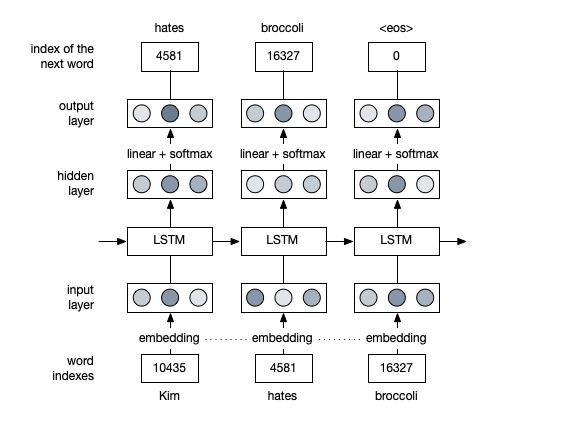

An input to the network is a vector of integers. In theory, this vector could represent a complete sentence or even the complete training data; for practical reasons, it is common to clip the length of the input at some fixed value *bptt_len*, the **backpropagation-through-time horizon**. Each integer is mapped to an embedding vector. The sequence of embedded vectors is then fed into an unrolled LSTM. At each position $i$ in the sequence, the hidden state of the LSTM at that position is sent through a linear transformation into a final softmax layer, from which we read off the index of the word at position $i+1$.

### Part 1: Vectorize the data

As in the previous problem, our first task is to transform the data in the WikiText container into a vectorized form that can be fed to the model.

In [ ]:
def vectorize_rnn(wikitext_data, bptt_len):
    xs, ys = [], []
    for i in range(0, len(wikitext_data) - bptt_len, bptt_len):
        xs.append(wikitext_data[i:i+bptt_len])
        ys.append(wikitext_data[i+1:i+bptt_len+1])
    return torch.LongTensor(xs), torch.LongTensor(ys)

The vectorization function transforms a list of token indexes into a pair of tensors $\mathbf{X}$, $\mathbf{Y}$. The rows of both tensors represent contiguous subsequences of token indexes of length *bptt_len*. Compared to the sequences in $\mathbf{X}$, the corresponding sequences in $\mathbf{Y}$ are shifted one position to the right (see the picture). More precisely, if the $i$th row of $\mathbf{X}$ is the sequence that starts at token position $j$, then the same row of $\mathbf{Y}$ is the sequence that starts at position $j+1$.

See whether you understand the representation by running the following cell:

In [ ]:
valid_x, valid_y = vectorize_rnn(wikitext.valid, 32)

print(valid_x.size())

### Part 2: Implement the model

Your next task is to implement the network model.

In [ ]:
import torch.nn as nn

class RNNModel(nn.Module):
    
    def __init__(self, n_words, embedding_dim=50, hidden_dim=50):
        super().__init__()
        # TODO: Add your own code

    def forward(self, x):
        # TODO: Replace the next line with your own code
        raise NotImplemented

Your implementation should follow this specification:

**__init__** (*self*, *n_words*, *embedding_dim*=50, *hidden_dim*=50)

> Creates a new recurrent neural network language model. The argument *n_words* is the number of words that need to be embedded. The optional arguments *embedding_dim* and *hidden_dim* specify the dimensionalities of the embedding layer and the LSTM hidden layer, respectively; their default value is 50.

**forward** (*self*, *x*)

> Computes the network output on an input batch *x*. The shape of *x* is $(B, H)$, where $B$ is the batch size and $H$ is the length of the backpropagation-through-time horizon. The shape of the output tensor is $(B, H, V)$, where $V$ is the size of the vocabulary (the number of words).

### Part 3: Train the model

The training loop for the recurrent neural network model is essentially identical to the loop that you wrote for the feed-forward model. The only thing to note is that the cross-entropy loss function expects it input to be a two-dimensional tensor; you will therefore have to re-shape the output tensor from the LSTM as well as the gold-standard output tensor in a suitable way. The most efficient way to do so is to use the [`view()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) method.

In [ ]:
def train_rnn(n_epochs=1, batch_size=100, bptt_len=32):
    train_x, train_y = vectorize_rnn(wikitext.train, bptt_len)
    valid_x, valid_y = vectorize_rnn(wikitext.valid, bptt_len)

    model = RNNModel(len(wikitext.vocab), embedding_dim=50, hidden_dim=50).to(device)
    optimizer = optim.Adam(model.parameters())

    # TODO: Insert your own code

    return None

Here is the specification of the training function:

**train_rnn** (*n_epochs*=1, *batch_size*=100, *bptt_len*=32)

> Trains a recurrent neural network language model on the WikiText data using minibatch gradient descent and returns it. The parameters *n_epochs* and *batch_size* specify the number of training epochs and the minibatch size, respectively. The parameter *bptt_len* specifies the length of the backpropagation-through-time horizon, that is, the length of the input and output sequences.

Test your model by running the following code cell:

In [ ]:
model_rnn = train_rnn()

You should see a perplexity that is significantly lower than the one obtained with the feed-forward model. To achieve optimal results, you would have to train for several epochs, using all samples in each epoch.

That&rsquo;s all, folks!